# Introdução

**Nesse primeiro notebook, nosso propósito é fazer uma análise inicial dos dados do dataset de bicicletas compartilhadas de nova iorque e entender suas peculiaridades nos dados.**

Dados Completos da Fonte: https://s3.amazonaws.com/tripdata/index.html

Acumulamos os dados no arquivo "0. Download Dados"

## Próximos Passos

**Análise de Dados:**
* [x] Análise básica dos dados
* [x] Limpeza dos dados
* [ ] Visualização de Dados Geográficos
    * [ ] Visualização dos pontos de saída e chegada
* [ ] Calcular distância absoluta de cada estação a outra.
* [ ] Analisar as estações mais populares
    * [ ] Separado por dia de semana / fim de semana
* [ ] Analisar os horários de pico e distribuição dos horários geral e por estação
* [ ] Analisar distribuição por dia, mês, ano da semana geral e por estação
* [ ] Analise de sazonalidade
* [ ] Relação do tempo da viagem com a idade e gênero da pessoa
* [ ] Distribuição por estação de idade e gênero
* [ ] Análise de corridas em grupo - mesmo inicio e fim? - pensar como avaliar isso

**Modelos:**
* [ ] Predizer para uma estação, em um dia da semana e horário, quantas corridas terá

**Tempo Real:**
* [ ] Obter dados em tempo real pela API
* [ ] Aplicar o modelo de predição nos dados reais, predizer para próximas horas
* [ ] Criar um dashboard em tempo real

# Importações

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import pyarrow.parquet as pq

In [3]:
from haversine import haversine

In [4]:
px.set_mapbox_access_token("pk.eyJ1Ijoicm1jbnJpYmVpcm8iLCJhIjoiY2s4MHh5b3ZiMGtsbTNkcGFuazR1dWc4diJ9._aDTNPlmw3Nt6QSMm3YgmQ")

**Importante**: Devido a restrição de espaço no Github, baixe os dados do Drive e coloque localmente na pasta 'Dados'.
https://drive.google.com/drive/folders/144_0BrEXS3Z1VslYxr1rP2Wr6bSm4tDf?usp=sharing

In [5]:
#2018
url='https://drive.google.com/file/d/1hDtZxxsYqPhHALDPm5qKMIp-sPINeQ0p/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_trips2018 = pd.read_parquet(url)

#2019
url='https://drive.google.com/file/d/10NQ5QdMQKBWw5-PpnCsjkmijXLYFFblb/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_trips2019 = pd.read_parquet(url)

df_trips = pd.concat([df_trips2018,df_trips2019])

# Análise Inicial

**Entendendo os tipos de dados e suas distribuições e comportamentos.**

In [6]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 16303534 to 499999
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tripduration             1000000 non-null  int64  
 1   starttime                1000000 non-null  object 
 2   stoptime                 1000000 non-null  object 
 3   start station id         999927 non-null   float64
 4   start station name       999927 non-null   object 
 5   start station latitude   1000000 non-null  float64
 6   start station longitude  1000000 non-null  float64
 7   end station id           999927 non-null   float64
 8   end station name         999927 non-null   object 
 9   end station latitude     1000000 non-null  float64
 10  end station longitude    1000000 non-null  float64
 11  bikeid                   1000000 non-null  int64  
 12  usertype                 1000000 non-null  object 
 13  birth year               1000000 non

**Verificando colunas com valores nulos.**

Precisaremos dropar essas linhas porque os IDs são relevantes na nossa análise.

In [7]:
df_trips.isna().any()

tripduration               False
starttime                  False
stoptime                   False
start station id            True
start station name          True
start station latitude     False
start station longitude    False
end station id              True
end station name            True
end station latitude       False
end station longitude      False
bikeid                     False
usertype                   False
birth year                 False
gender                     False
dtype: bool

**Mapeamento de Colunas para padronizar os nomes.**

In [8]:
df_trips = df_trips.rename(
    columns={
        'starttime': "Start Time", 
        'stoptime': "Stop Time", 
        'start station id': "Start Station ID", 
        'start station name': "Start Station Name",
        'start station latitude': "Start Station Latitude", 
        'start station longitude': "Start Station Longitude", 
        'end station id': "End Station ID",
        'end station name': "End Station Name", 
        'end station latitude': "End Station Latitude", 
        'end station longitude': "End Station Longitude",
        'bikeid': "Bike ID", 
        'usertype': "User Type", 
        'birth year': "Birth Year", 
        'gender': "Gender",
        'tripduration': "Trip Duration"
    }
)

In [9]:
df_trips.columns

Index(['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender'],
      dtype='object')

In [10]:
df_trips["Start Time"] = pd.to_datetime(df_trips["Start Time"])
df_trips["Stop Time"] = pd.to_datetime(df_trips["Stop Time"])

In [11]:
# Adicionando Coluna de Tempo Total em Minutos
df_trips["Trip Duration Minutes"] = df_trips["Trip Duration"]/60.0

In [12]:
df_trips.describe()

Trip Duration  Start Station ID  Start Station Latitude  \
count   1.000000e+06     999927.000000          1000000.000000   
mean    9.585321e+02       1626.302095               40.737297   
std     1.074404e+04       1459.005319                0.032325   
min     6.100000e+01         72.000000               40.646538   
25%     3.600000e+02        380.000000               40.717548   
50%     6.110000e+02        508.000000               40.738046   
75%     1.071000e+03       3263.000000               40.757570   
max     4.845976e+06       3911.000000               45.506364   

       Start Station Longitude  End Station ID  End Station Latitude  \
count           1000000.000000   999927.000000        1000000.000000   
mean                -73.982313     1614.832814             40.736973   
std                   0.019402     1457.806272              0.032145   
min                 -74.025353       72.000000             40.646538   
25%                 -73.995168      380.000000             40.717548   
50%                 -73.985417      507.000000             40.737262   
75%                 -73.971888     3260.000000             40.757148   
max                 -73.568906     3911.000000             45.506364   

       End Station Longitude         Bike ID      Birth Year          Gender  \
count         1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean              -73.982545    28129.741087     1979.596311        1.156034   
std                 0.019470     7101.626969       12.042405        0.541274   
min               -74.044247    14529.000000     1885.000000        0.000000   
25%               -73.995481    21265.000000     1969.000000        1.000000   
50%               -73.986022    29791.000000     1982.000000        1.000000   
75%               -73.972652    33128.000000     1989.000000        1.000000   
max               -73.568906    42046.000000     2003.000000        2.000000   

       Trip Duration Minutes  
count         1000000.000000  
mean               15.975534  
std               179.067339  
min                 1.016667  
25%                 6.000000  
50%                10.183333  
75%                17.850000  
max             80766.266667

**Observações de Dados:**

* Máximo de Trip duration muito alta
* Longitude possui valores zerados, indicando trips não finalizadas. Provavelmente vamos dropar.
* Birth Year mínimo de 1857 - precisamos ver a veracidade dessa coluna
* Gender 0, 1, 2 - precisamos verificar os significados
* Trip Duration Minutes com máximo muito alto
* Dados nulos de ID e Name

## Tratando Dados Nulos

In [13]:
df_trips = df_trips.dropna()

In [14]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999927 entries, 16303534 to 499999
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Trip Duration            999927 non-null  int64         
 1   Start Time               999927 non-null  datetime64[ns]
 2   Stop Time                999927 non-null  datetime64[ns]
 3   Start Station ID         999927 non-null  float64       
 4   Start Station Name       999927 non-null  object        
 5   Start Station Latitude   999927 non-null  float64       
 6   Start Station Longitude  999927 non-null  float64       
 7   End Station ID           999927 non-null  float64       
 8   End Station Name         999927 non-null  object        
 9   End Station Latitude     999927 non-null  float64       
 10  End Station Longitude    999927 non-null  float64       
 11  Bike ID                  999927 non-null  int64         
 12  User Type

In [15]:
df_trips.loc[:, "Start Station ID"] = df_trips.loc[:, "Start Station ID"].astype(int).values
df_trips.loc[:, "End Station ID"] = df_trips.loc[:, "End Station ID"].astype(int).values

In [16]:
df_trips.head()

Trip Duration              Start Time               Stop Time  \
16303534            882 2018-11-25 18:21:38.774 2018-11-25 18:36:21.472   
10311866            669 2018-08-13 18:25:50.544 2018-08-13 18:36:59.968   
17229606            521 2018-12-18 20:12:15.062 2018-12-18 20:20:57.017   
4463430             270 2018-05-18 14:23:52.105 2018-05-18 14:28:22.491   
10376436            441 2018-08-14 19:00:15.867 2018-08-14 19:07:37.052   

          Start Station ID          Start Station Name  \
16303534               423             W 54 St & 9 Ave   
10311866              3467  W Broadway & Spring Street   
17229606               411           E 6 St & Avenue D   
4463430                437     Macon St & Nostrand Ave   
10376436               519       Pershing Square North   

          Start Station Latitude  Start Station Longitude  End Station ID  \
16303534               40.765849               -73.986905             476   
10311866               40.724947               -74.001659             327   
17229606               40.722281               -73.976687             504   
4463430                40.680983               -73.950048            3047   
10376436               40.751873               -73.977706             498   

                  End Station Name  End Station Latitude  \
16303534           E 31 St & 3 Ave             40.743943   
10311866  Vesey Pl & River Terrace             40.715338   
17229606           1 Ave & E 16 St             40.732219   
4463430   Halsey St & Tompkins Ave             40.682369   
10376436        Broadway & W 32 St             40.748549   

          End Station Longitude  Bike ID   User Type  Birth Year  Gender  \
16303534             -73.979661    20049    Customer        1969       0   
10311866             -74.016584    33847  Subscriber        1987       1   
17229606             -73.981656    30284  Subscriber        1971       1   
4463430              -73.944118    31542  Subscriber        1964       1   
10376436             -73.988084    18363  Subscriber        1979       1   

          Trip Duration Minutes  
16303534              14.700000  
10311866              11.150000  
17229606               8.683333  
4463430                4.500000  
10376436               7.350000

## Análise de Trip Duration - Semelhante a Trip_Duration_in_min

In [17]:
trip_durations = df_trips["Trip Duration Minutes"]

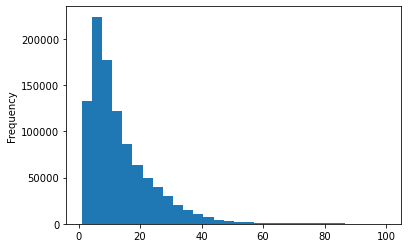

In [18]:
trip_durations[trip_durations < 100].plot.hist(bins=30)

## Análise de Birth Year

In [19]:
birth_years = df_trips["Birth Year"]

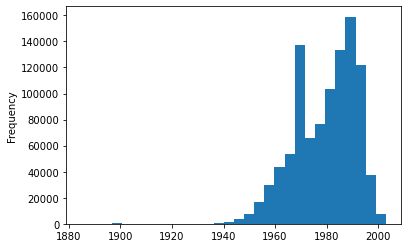

In [20]:
birth_years.plot.hist(bins=30)

Criação de Nova Coluna de Idade:

In [21]:
data_captura = 2019
df_trips["Age"] = data_captura - df_trips["Birth Year"]

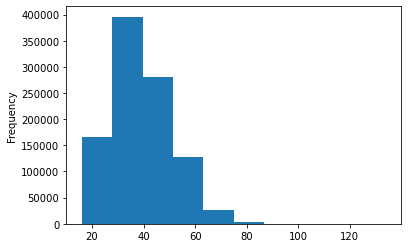

In [22]:
df_trips["Age"].plot.hist()

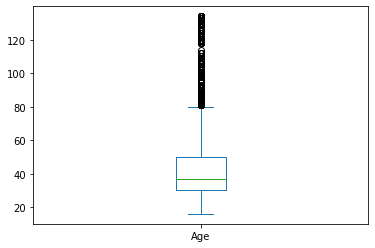

In [23]:
df_trips["Age"].plot.box()

## Unicidade de (latitude, longitude) para cada uma das Stops

Será que os dados de latitude e longitude das stops é consistente ou aparecem múltiplos (lat, long) para um mesmo stop?

In [24]:
# Obtendo as colunas relacionadas a start stops
start_stations = df_trips[['Start Station ID', 'Start Station Latitude', 'Start Station Longitude', 'Start Station Name']]
start_stations.columns = ['Station ID', 'Station Latitude', 'Station Longitude', 'Station Name']

In [25]:
# Obtendo as colunas relacionadas a end stops
end_stations = df_trips[['End Station ID', 'End Station Latitude', 'End Station Longitude', 'End Station Name']]
end_stations.columns = ['Station ID', 'Station Latitude', 'Station Longitude', 'Station Name']

In [26]:
# Uniao das stops, ja que ser de inicio ou fim nao importa
stations = pd.concat([start_stations, end_stations], axis=0, ignore_index=True)

In [27]:
stations.head()

Station ID  Station Latitude  Station Longitude                Station Name
0         423         40.765849         -73.986905             W 54 St & 9 Ave
1        3467         40.724947         -74.001659  W Broadway & Spring Street
2         411         40.722281         -73.976687           E 6 St & Avenue D
3         437         40.680983         -73.950048     Macon St & Nostrand Ave
4         519         40.751873         -73.977706       Pershing Square North

In [28]:
# Verificando se todos os grupos de Station ID possuem apenas 1 linha após dropar duplicatas
(stations.drop_duplicates().groupby("Station ID").size() == 1).all()

False

In [29]:
stations.drop_duplicates().groupby("Station ID").size().sort_values()

Station ID
72      1
3501    1
3502    1
3503    1
3504    1
       ..
3243    2
243     2
517     2
3727    2
3466    3
Length: 988, dtype: int64

### Definindo um Dataframe mapeador das stations

Pode ser útil mais tarde termos um mapeador da station id para a lat, long

In [30]:
df_stations = stations.drop_duplicates().set_index('Station ID')

In [31]:
df_stations.head()

Station Latitude  Station Longitude                Station Name
Station ID                                                                 
423                40.765849         -73.986905             W 54 St & 9 Ave
3467               40.724947         -74.001659  W Broadway & Spring Street
411                40.722281         -73.976687           E 6 St & Avenue D
437                40.680983         -73.950048     Macon St & Nostrand Ave
519                40.751873         -73.977706       Pershing Square North

# Data Augmentation

In [32]:
df_trips["isweekend"] = df_trips["Start Time"].dt.weekday >= 5

In [33]:
df_trips["weekday"] = df_trips["Start Time"].dt.weekday

# Limpeza de Dados

**Observações de Dados:**

* Máximo de Trip duration muito alta
* Longitude possui valores zerados, indicando trips não finalizadas. Provavelmente vamos dropar.
* Birth Year mínimo de 1900 - precisamos ver a veracidade dessa coluna
* Gender 0, 1, 2 - precisamos verificar os significados
* Trip_Duration_in_min com máximo muito alto
* Nenhum dado nulo no dataset

In [34]:
df_trips_filtrado = df_trips

## Trip Duration

In [35]:
trip_duration = df_trips_filtrado["Trip Duration"]

In [36]:
Q1 = trip_duration.quantile(0.25)
Q3 = trip_duration.quantile(0.75)
IQR = Q3 - Q1

In [37]:
duration_filter = ~((trip_duration < (Q1 - 1.5 * IQR)) |(trip_duration > (Q3 + 1.5 * IQR)))
df_trips_filtrado = df_trips[duration_filter]

In [38]:
df_trips_filtrado

Trip Duration              Start Time               Stop Time  \
16303534            882 2018-11-25 18:21:38.774 2018-11-25 18:36:21.472   
10311866            669 2018-08-13 18:25:50.544 2018-08-13 18:36:59.968   
17229606            521 2018-12-18 20:12:15.062 2018-12-18 20:20:57.017   
4463430             270 2018-05-18 14:23:52.105 2018-05-18 14:28:22.491   
10376436            441 2018-08-14 19:00:15.867 2018-08-14 19:07:37.052   
...                 ...                     ...                     ...   
499995             1658 2019-06-12 22:09:26.375 2019-06-12 22:37:05.244   
499996              294 2019-10-04 15:13:45.883 2019-10-04 15:18:40.101   
499997             1386 2019-06-09 13:46:00.828 2019-06-09 14:09:07.822   
499998             1648 2019-09-26 17:48:29.830 2019-09-26 18:15:57.963   
499999              506 2019-05-29 16:56:05.696 2019-05-29 17:04:32.584   

          Start Station ID          Start Station Name  \
16303534               423             W 54 St & 9 Ave   
10311866              3467  W Broadway & Spring Street   
17229606               411           E 6 St & Avenue D   
4463430                437     Macon St & Nostrand Ave   
10376436               519       Pershing Square North   
...                    ...                         ...   
499995                3310               14 St & 7 Ave   
499996                3062      Myrtle Ave & Marcy Ave   
499997                 311      Norfolk St & Broome St   
499998                 266           Avenue D & E 8 St   
499999                3345       Madison Ave & E 99 St   

          Start Station Latitude  Start Station Longitude  End Station ID  \
16303534               40.765849               -73.986905             476   
10311866               40.724947               -74.001659             327   
17229606               40.722281               -73.976687             504   
4463430                40.680983               -73.950048            3047   
10376436               40.751873               -73.977706             498   
...                          ...                      ...             ...   
499995                 40.663779               -73.983968             414   
499996                 40.695398               -73.949549             373   
499997                 40.717227               -73.988021             143   
499998                 40.723684               -73.975748            3680   
499999                 40.789485               -73.952429            3507   

                      End Station Name  End Station Latitude  \
16303534               E 31 St & 3 Ave             40.743943   
10311866      Vesey Pl & River Terrace             40.715338   
17229606               1 Ave & E 16 St             40.732219   
4463430       Halsey St & Tompkins Ave             40.682369   
10376436            Broadway & W 32 St             40.748549   
...                                ...                   ...   
499995         Pearl St & Anchorage Pl             40.702819   
499996    Willoughby Ave & Walworth St             40.693317   
499997       Clinton St & Joralemon St             40.692395   
499998                 E 43 St & 5 Ave             40.754121   
499999             Park Ave & E 124 St             40.804555   

          End Station Longitude  Bike ID   User Type  Birth Year  Gender  \
16303534             -73.979661    20049    Customer        1969       0   
10311866             -74.016584    33847  Subscriber        1987       1   
17229606             -73.981656    30284  Subscriber        1971       1   
4463430              -73.944118    31542  Subscriber        1964       1   
10376436             -73.988084    18363  Subscriber        1979       1   
...                         ...      ...         ...         ...     ...   
499995               -73.987658    34104  Subscriber        1981       2   
499996               -73.953820    14887  Subscriber        1986       1   
499997               -73.993379   

## Latitude e Longitude Zerados

A filtragem anterior resolveu o problema.

In [39]:
df_trips_filtrado.describe()

Trip Duration  Start Station ID  Start Station Latitude  \
count  953477.000000     953477.000000           953477.000000   
mean      716.036892       1614.724099               40.737126   
std       472.513582       1457.335650                0.031392   
min        61.000000         72.000000               40.646538   
25%       350.000000        380.000000               40.717548   
50%       582.000000        507.000000               40.737815   
75%       980.000000       3260.000000               40.757148   
max      2137.000000       3911.000000               45.506364   

       Start Station Longitude  End Station ID  End Station Latitude  \
count            953477.000000   953477.000000         953477.000000   
mean                -73.982401     1602.125085             40.736856   
std                   0.019279     1456.040895              0.031183   
min                 -74.025353       72.000000             40.646538   
25%                 -73.995101      379.000000             40.717548   
50%                 -73.985649      505.000000             40.737262   
75%                 -73.972095     3260.000000             40.756604   
max                 -73.568906     3911.000000             45.506364   

       End Station Longitude        Bike ID     Birth Year         Gender  \
count          953477.000000  953477.000000  953477.000000  953477.000000   
mean              -73.982631   28132.736604    1979.657273       1.162816   
std                 0.019348    7096.604495      12.043719       0.531320   
min               -74.042817   14529.000000    1885.000000       0.000000   
25%               -73.995299   21275.000000    1969.000000       1.000000   
50%               -73.986022   29793.000000    1982.000000       1.000000   
75%               -73.972834   33121.000000    1989.000000       1.000000   
max               -73.568906   42046.000000    2003.000000       2.000000   

       Trip Duration Minutes            Age        weekday  
count          953477.000000  953477.000000  953477.000000  
mean               11.933948      39.342727       2.846752  
std                 7.875226      12.043719       1.929776  
min                 1.016667      16.000000       0.000000  
25%                 5.833333      30.000000       1.000000  
50%                 9.700000      37.000000       3.000000  
75%                16.333333      50.000000       4.000000  
max                35.616667     134.000000       6.000000

# Análise das Distâncias 'Percorridas'

In [40]:
df_trips["Distâncias"] = df_trips.apply(lambda linha:haversine((linha['Start Station Latitude'] , linha['Start Station Longitude']), (linha['End Station Latitude'], linha['End Station Longitude'])),axis=1)

# Análise das Estações Populares

In [41]:
df_trips_filtrado_fim_semana = df_trips_filtrado[df_trips_filtrado.isweekend]

In [42]:
df_trips_filtrado_dia_semana = df_trips_filtrado[~df_trips_filtrado.isweekend]

## Populares de Início - Dias de Semana

In [43]:
popularidade_start_stations = df_trips_filtrado_dia_semana['Start Station ID'].value_counts().rename("Start Station Count")

In [44]:
popularidade_start_stations.head()

519     6942
497     4561
402     4549
3255    4319
435     4271
Name: Start Station Count, dtype: int64

In [45]:
df_stations.head()

Station Latitude  Station Longitude                Station Name
Station ID                                                                 
423                40.765849         -73.986905             W 54 St & 9 Ave
3467               40.724947         -74.001659  W Broadway & Spring Street
411                40.722281         -73.976687           E 6 St & Avenue D
437                40.680983         -73.950048     Macon St & Nostrand Ave
519                40.751873         -73.977706       Pershing Square North

In [46]:
df_start_station_count = df_stations.merge(popularidade_start_stations, right_index=True, left_index=True).sort_values("Start Station Count", ascending=False)

In [47]:
df_start_station_count.head()

Station Latitude  Station Longitude           Station Name  \
519          40.751873         -73.977706  Pershing Square North   
497          40.737050         -73.990093     E 17 St & Broadway   
402          40.740343         -73.989551     Broadway & E 22 St   
3255         40.750585         -73.994685        8 Ave & W 31 St   
435          40.741740         -73.994156        W 21 St & 6 Ave   

      Start Station Count  
519                  6942  
497                  4561  
402                  4549  
3255                 4319  
435                  4271

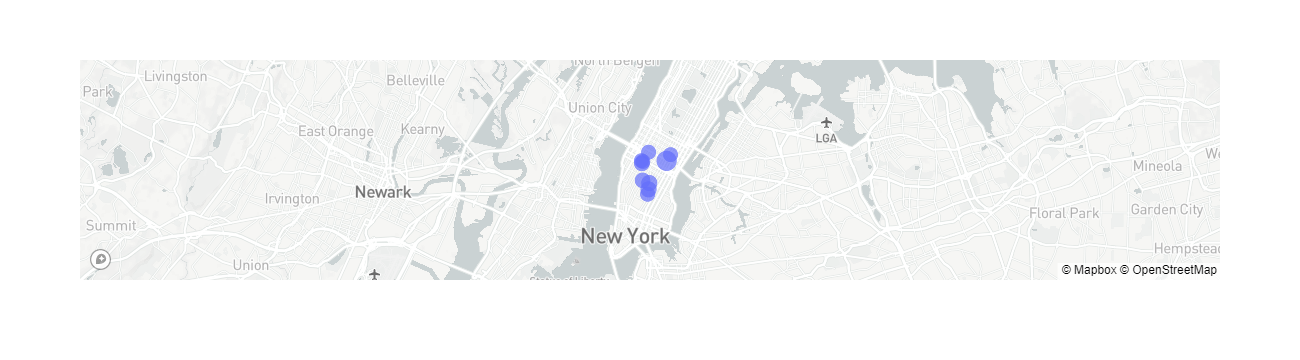

In [48]:
fig = px.scatter_mapbox(
    df_start_station_count.head(10), lat="Station Latitude", lon="Station Longitude", size="Start Station Count",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

### Conclusão Parcial

To be Done...

## Populares de Início - Fins de Semana

In [49]:
popularidade_start_stations = df_trips_filtrado_fim_semana['Start Station ID'].value_counts().rename("Start Station Count")

In [50]:
popularidade_start_stations.head()

435    1352
497    1325
285    1307
426    1295
499    1222
Name: Start Station Count, dtype: int64

In [51]:
df_stations.head()

Station Latitude  Station Longitude                Station Name
Station ID                                                                 
423                40.765849         -73.986905             W 54 St & 9 Ave
3467               40.724947         -74.001659  W Broadway & Spring Street
411                40.722281         -73.976687           E 6 St & Avenue D
437                40.680983         -73.950048     Macon St & Nostrand Ave
519                40.751873         -73.977706       Pershing Square North

In [52]:
df_start_station_count = df_stations.merge(popularidade_start_stations, right_index=True, left_index=True).sort_values("Start Station Count", ascending=False)

In [53]:
df_start_station_count.head()

Station Latitude  Station Longitude           Station Name  \
435         40.741740         -73.994156        W 21 St & 6 Ave   
497         40.737050         -73.990093     E 17 St & Broadway   
285         40.734546         -73.990741     Broadway & E 14 St   
426         40.717548         -74.013221  West St & Chambers St   
499         40.769155         -73.981918     Broadway & W 60 St   

     Start Station Count  
435                 1352  
497                 1325  
285                 1307  
426                 1295  
499                 1222

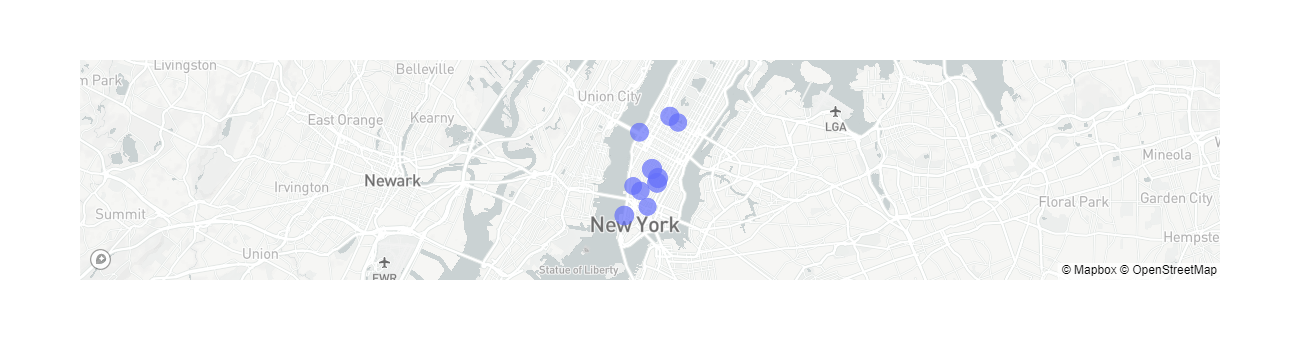

In [54]:
fig = px.scatter_mapbox(
    df_start_station_count.head(10), lat="Station Latitude", lon="Station Longitude", size="Start Station Count",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

### Conclusão Parcial

To be Done...

## Populares de Fim - Dias de Semana

In [55]:
popularidade_end_stations = df_trips_filtrado_dia_semana['End Station ID'].value_counts().rename("End Station Count")

In [56]:
popularidade_end_stations.head()

519     7160
402     4891
497     4573
435     4443
3255    4411
Name: End Station Count, dtype: int64

In [57]:
df_stations.head()

Station Latitude  Station Longitude                Station Name
Station ID                                                                 
423                40.765849         -73.986905             W 54 St & 9 Ave
3467               40.724947         -74.001659  W Broadway & Spring Street
411                40.722281         -73.976687           E 6 St & Avenue D
437                40.680983         -73.950048     Macon St & Nostrand Ave
519                40.751873         -73.977706       Pershing Square North

In [58]:
df_end_station_count = df_stations.merge(popularidade_end_stations, right_index=True, left_index=True).sort_values("End Station Count", ascending=False)

In [59]:
df_end_station_count.head()

Station Latitude  Station Longitude           Station Name  \
519          40.751873         -73.977706  Pershing Square North   
402          40.740343         -73.989551     Broadway & E 22 St   
497          40.737050         -73.990093     E 17 St & Broadway   
435          40.741740         -73.994156        W 21 St & 6 Ave   
3255         40.750585         -73.994685        8 Ave & W 31 St   

      End Station Count  
519                7160  
402                4891  
497                4573  
435                4443  
3255               4411

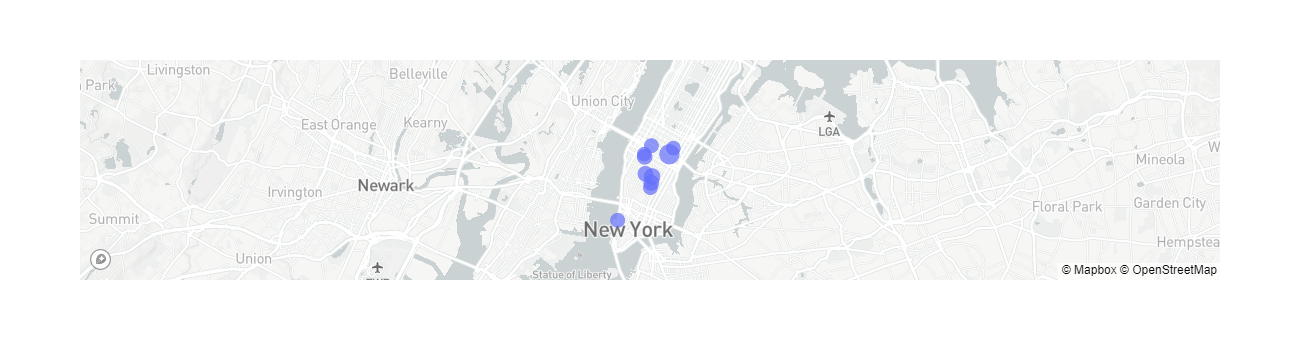

In [60]:
fig = px.scatter_mapbox(
    df_end_station_count.head(10), lat="Station Latitude", lon="Station Longitude", size="End Station Count",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

### Conclusão Parcial

To be Done...

## Populares de Fim - Fins de Semana

In [61]:
popularidade_end_stations = df_trips_filtrado_fim_semana['End Station ID'].value_counts().rename("End Station Count")

In [62]:
popularidade_end_stations.head()

497    1439
285    1362
426    1317
435    1308
499    1271
Name: End Station Count, dtype: int64

In [63]:
df_stations.head()

Station Latitude  Station Longitude                Station Name
Station ID                                                                 
423                40.765849         -73.986905             W 54 St & 9 Ave
3467               40.724947         -74.001659  W Broadway & Spring Street
411                40.722281         -73.976687           E 6 St & Avenue D
437                40.680983         -73.950048     Macon St & Nostrand Ave
519                40.751873         -73.977706       Pershing Square North

In [64]:
df_end_station_count = df_stations.merge(popularidade_end_stations, right_index=True, left_index=True).sort_values("End Station Count", ascending=False)

In [65]:
df_end_station_count.head()

Station Latitude  Station Longitude           Station Name  \
497         40.737050         -73.990093     E 17 St & Broadway   
285         40.734546         -73.990741     Broadway & E 14 St   
426         40.717548         -74.013221  West St & Chambers St   
435         40.741740         -73.994156        W 21 St & 6 Ave   
499         40.769155         -73.981918     Broadway & W 60 St   

     End Station Count  
497               1439  
285               1362  
426               1317  
435               1308  
499               1271

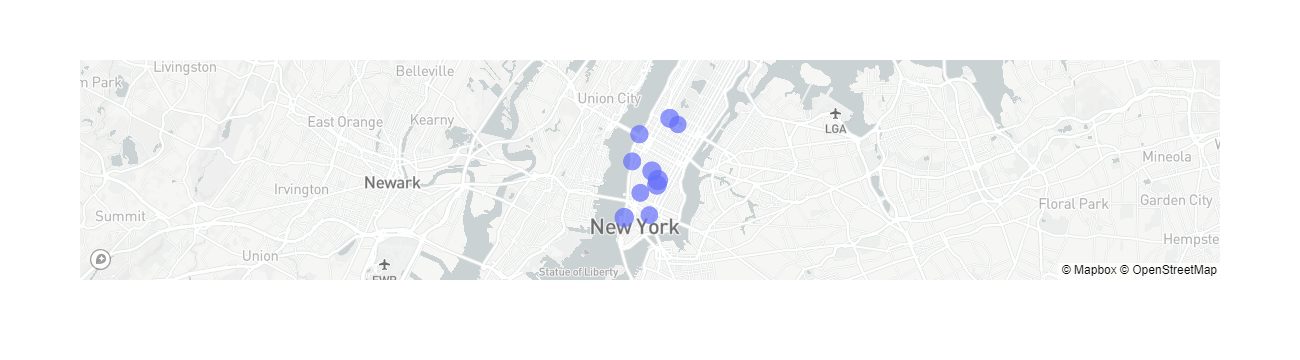

In [66]:
fig = px.scatter_mapbox(
    df_end_station_count.head(10), lat="Station Latitude", lon="Station Longitude", size="End Station Count",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

### Conclusão Parcial

To be Done...

## Conclusões sobre as Popularidades

To be done...

# Análise dos Horários de Pico

In [67]:
df_trips_filtrado_fim_semana = df_trips_filtrado[df_trips_filtrado.isweekend]

In [68]:
df_trips_filtrado_dia_semana = df_trips_filtrado[~df_trips_filtrado.isweekend]

## Separado por Weekday

In [69]:
df_horarios_pico = df_trips_filtrado.copy()

In [70]:
df_horarios_pico['Hour'] = df_horarios_pico['Start Time'].dt.hour

In [71]:
df_horarios_pico[['weekday', 'Hour']].head()

weekday  Hour
16303534        6    18
10311866        0    18
17229606        1    20
4463430         4    14
10376436        1    19

In [72]:
hour_distribution = pd.pivot_table(df_horarios_pico[['weekday', 'Hour']], columns='weekday', index='Hour', aggfunc=len)

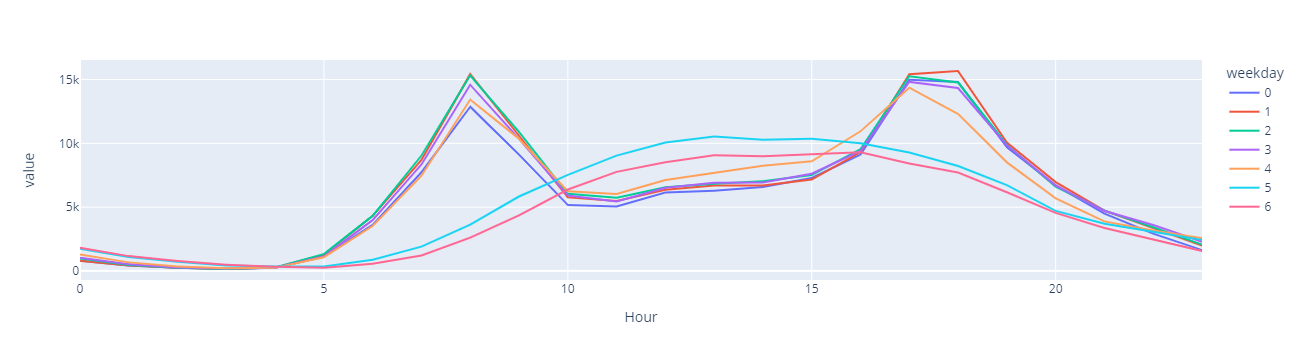

In [73]:
px.line(hour_distribution)

### Conclusão

To be done...

# Análise do Uso por Dia da Semana

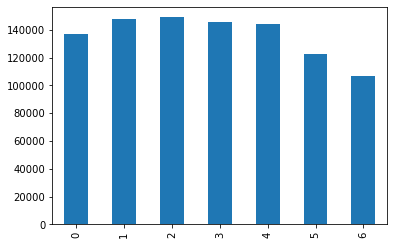

In [74]:
df_trips_filtrado['weekday'].value_counts().sort_index().plot.bar()

# Salvamento do DF Final para Proximos Notebooks

In [76]:
df_trips_filtrado.to_parquet("../Dados/df_trips_filtrado.parquet")